<a href="https://colab.research.google.com/github/RD191295/Pytorch-Tutorials/blob/main/01_Pytorch_Workflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Pytorch WorkFlow

Let's explore a an example Pytorch end-to-end workflow.

1. Data Prepare and Load
2. Build Model
3. Fitting the model to data (training)
4. Making predictions and evaluting a model (inference)
5. Saving and loading a model
6. Putting at all together

In [1]:
import torch
from torch import nn # nn contains all of pytorch's all building block of nerual network
import matplotlib.pyplot as plt


# check Pytorch version
torch.__version__

'2.0.0+cu118'

## 1. Data(Preparing and Loading)

<li>Data Can be almost anything Like:</li>

* Excel Speadsheet,csv
* Images of any kind
* Videos
* Audio like songs or podcasts
* DNA
* Text

Machine Learning is a game of two parts:
1. Get Data  into a numerical representation.
2. Build Model to learn patterns in that numerical representation.

In [2]:
# CREATE *Known* parameters
weight = 0.7
bias = 0.3

# Create Data
start = 0
end = 1
step = 0.02

# define X and Y
X = torch.arange(start, end, step).unsqueeze(dim = 1)
Y = weight * X + bias

X[:10],Y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

### Spliting the data into training and test sets

In [3]:
# create a train/test split

train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], Y[:train_split]
X_test, y_test = X[train_split:],Y[train_split:]

## Visualizing Data !!!

In [28]:
def plot_predictions(train_data = X_train,
                      train_labels = y_train,
                      test_data = X_test,
                      test_labels = y_test,
                      predictions = None):
  
  plt.figure(figsize = (16,14))

  #plot training data in blue
  plt.scatter(train_data, train_labels, c="b", label = "Training Data")
  
  #plot testing data in green
  plt.scatter(test_data, test_labels, c="g", label = "Testing Data")

  # Are there predictions
  if predictions is not None:
    # plot predictions if they exist
    plt.scatter(test_data, predictions, c="r", label = "Predictions")

  
  plt.legend(prop = {"size":14})


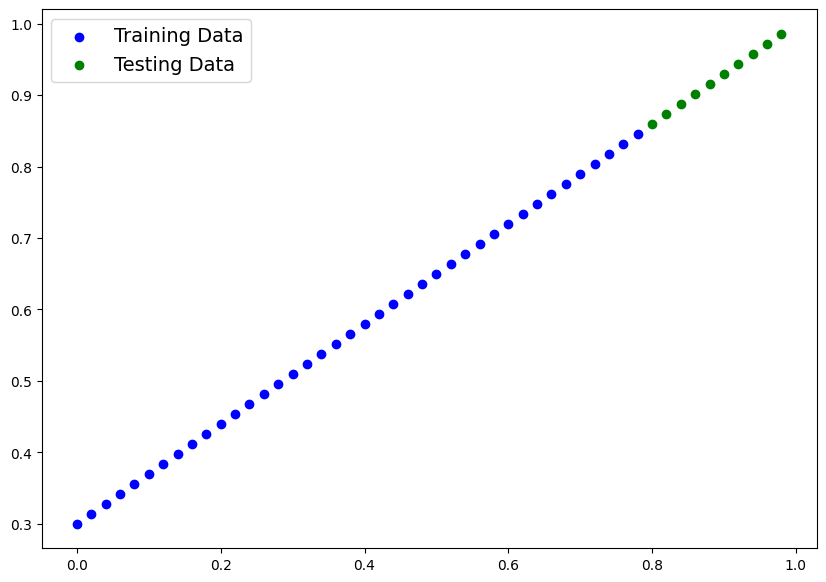

In [5]:
plot_predictions()

## 2. Buid Model



In [6]:
class LinearRegressionModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.weights = nn.Parameter(torch.randn(1, # <- start with random weights (this will get adjusted as the model learns)
                                                dtype=torch.float), # <- PyTorch loves float32 by default
                                   requires_grad=True) # <- can we update this value with gradient descent?)

    self.bias = nn.Parameter(torch.randn(1, # <- start with random bias (this will get adjusted as the model learns)
                                            dtype=torch.float), # <- PyTorch loves float32 by default
                                requires_grad=True) # <- can we update this value with gradient descent?))

    
  # forward method to define compution in the model
  def forward(self, x: torch.Tensor):
    return self.weights*x + self.bias # this is linear regression formula

### Pytorch Model Building essentials

PyTorch module	What does it do?
* torch.nn	Contains all of the building blocks for computational graphs (essentially a series of computations executed in a particular way).
* torch.nn.Parameter	Stores tensors that can be used with nn.Module. If requires_grad=True gradients (used for updating model parameters via gradient descent) are calculated automatically, this is often referred to as "autograd".
* torch.nn.Module	The base class for all neural network modules, all the building blocks for neural networks are subclasses. If you're building a neural network in PyTorch, your models should subclass nn.Module. Requires a forward() method be implemented.
* torch.optim	Contains various optimization algorithms (these tell the model parameters stored in nn.Parameter how to best change to improve gradient descent and in turn reduce the loss).
* def forward()	All nn.Module subclasses require a forward() method, this defines the computation that will take place on the data passed to the particular nn.Module (e.g. the linear regression formula above).

### Checking the contents of our Pytorch Model

Now we have created model , let see what inside the model !!

So we can check our model parameters :

In [7]:
# create a random seed
torch.manual_seed(42)

# create an instance of the model ( this is a subclass of nn.Module)
model_0 = LinearRegressionModel()

# check out the parameters.
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [8]:
# List named parameters 
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

### Making Prediction using 'torch.inference_mode()

To check our model's predictive power, let's see how well it predicts y_test based on X_test

when we pass data through our model,it's going to run it through the forward() method

In [9]:
with torch.inference_mode():
  y_preds = model_0(X_test)

y_preds

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])

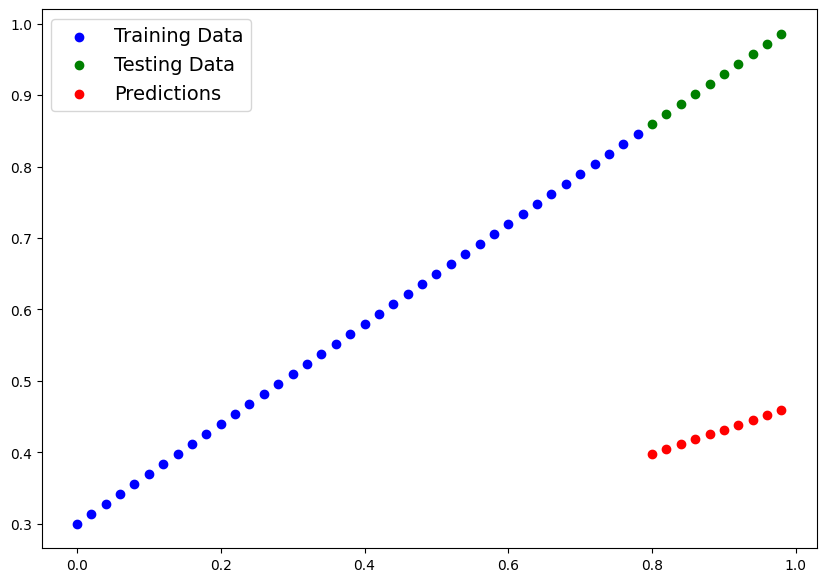

In [10]:
#ploting graph with predictions
plot_predictions(predictions = y_preds)

## 3. Train Model

The whole idea of training is for a model to move from some **unknown** parameters.


or in other words from a poor representation of the data to a better representation of the data.

one way to measure how poor or how wrong your models predictions are to use a loss function.

* Note: Loss function may also be called a cost function or criterion in different areas, for our case we are going to refer to it as a loss funvtion

Things we need to train:
* **Loss Function** : A function to measure how wrong your models' predictions are to the ideal outputs, lower is better.
* **Optimizer** : Takes into account the loss of a model and adjusts the model's parameter( e.g. weight & bias)

In [11]:
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [12]:
# Setup a loss function
loss_fn = nn.L1Loss()

# setup an Optimizer
Optimizer = torch.optim.SGD(params = model_0.parameters(), 
                            lr = 0.01)# lr ---> learning rate

### Building a training loop (and a testing loop) in PyTorch

A Couple of things we need in a training loop:
* Loop through the data
* Forward Pass ( thisa involves data moving through our model's `forward()` functions) to make prediction on data - also called forward propogation
* Calculate the loss(compare forward pass predictions to ground truth labels)
* Optimizer zero grad
* Loss Backward - move backwards through the netwrok to calculate the gradients of each of the parameters of our model with respect to the loss (**backpropogation**)
* Optimizer step - use the optimizer to adjust our model's parameters to try and improve the loss.(**Gradient descent**)

In [13]:
# An epoch is one loop through the data
epochs = 200

# Loop through the data
for epoch in range(epochs):
  # set the model to training mode
  model_0.train() # train mode in PyTorch Sets all parameters that requires gradients
  
  # Forward Pass
  y_pred = model_0.forward(X_train)

  # calculate loss
  loss = loss_fn(y_pred,y_train)
  
  #Optimizer zero grad
  Optimizer.zero_grad()

  # backward prapogation
  loss.backward()
  
   # step the optimizer
  Optimizer.step()
  ### Testing
  model_0.eval()
  with torch.inference_mode(): # turns off gradient tracking & a couple more things behind the scenes
    #1. Do the forward pass
    test_pred = model_0(X_test)

    # 2. calculate loss
    test_loss = loss_fn(test_pred,y_test)
  
  #print Loss 
  if epoch % 10 == 0:
    print(f"Epoch : {epoch} | Loss : {loss} | Test Loss : {test_loss}")

Epoch : 0 | Loss : 0.31288138031959534 | Test Loss : 0.48106518387794495
Epoch : 10 | Loss : 0.1976713240146637 | Test Loss : 0.3463551998138428
Epoch : 20 | Loss : 0.08908725529909134 | Test Loss : 0.21729660034179688
Epoch : 30 | Loss : 0.053148526698350906 | Test Loss : 0.14464017748832703
Epoch : 40 | Loss : 0.04543796554207802 | Test Loss : 0.11360953003168106
Epoch : 50 | Loss : 0.04167863354086876 | Test Loss : 0.09919948130846024
Epoch : 60 | Loss : 0.03818932920694351 | Test Loss : 0.08886633068323135
Epoch : 70 | Loss : 0.03476089984178543 | Test Loss : 0.0805937647819519
Epoch : 80 | Loss : 0.03132382780313492 | Test Loss : 0.07232122868299484
Epoch : 90 | Loss : 0.02788739837706089 | Test Loss : 0.06473556160926819
Epoch : 100 | Loss : 0.024458957836031914 | Test Loss : 0.05646304413676262
Epoch : 110 | Loss : 0.021020207554101944 | Test Loss : 0.04819049686193466
Epoch : 120 | Loss : 0.01758546568453312 | Test Loss : 0.04060482233762741
Epoch : 130 | Loss : 0.0141553934663

In [14]:
list(model_0.parameters())

[Parameter containing:
 tensor([0.6990], requires_grad=True),
 Parameter containing:
 tensor([0.3093], requires_grad=True)]

In [15]:
with torch.inference_mode():
  y_preds = model_0(X_test)

y_preds

tensor([[0.8685],
        [0.8825],
        [0.8965],
        [0.9105],
        [0.9245],
        [0.9384],
        [0.9524],
        [0.9664],
        [0.9804],
        [0.9944]])

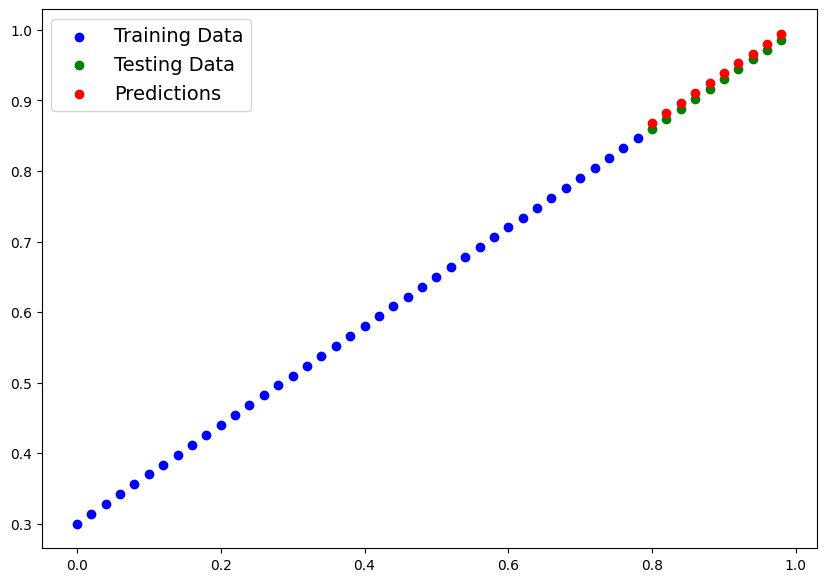

In [16]:
#ploting graph with predictions
plot_predictions(predictions = y_preds)

### Saving a Model in Pytorch

In [17]:
# saving our Pytorch model
from pathlib import Path

# Create models Directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents = True, exist_ok = True)

# Model Save Path
MODEL_NAME = "01_pytorch_workflow_model_0.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

#Save Model(Stat_dict)
torch.save(model_0.state_dict(),
           f = MODEL_SAVE_PATH)

## Loading Pytorch Model

* Since we saved our model's `state_dict`() rather than entire model, we will create new instance of our model class and state_dict() into that

In [18]:
# create new instance of model
loaded_model_0 = LinearRegressionModel()

# load the saved state dict of model_0
loaded_model_0.load_state_dict(torch.load(f = MODEL_SAVE_PATH))

<All keys matched successfully>

In [19]:
loaded_model_0.state_dict()

OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))])

In [20]:
# Make some predictions with our loaded model
loaded_model_0.eval()
with torch.inference_mode():
  loaded_model_preds = loaded_model_0(X_test)
loaded_model_preds

tensor([[0.8685],
        [0.8825],
        [0.8965],
        [0.9105],
        [0.9245],
        [0.9384],
        [0.9524],
        [0.9664],
        [0.9804],
        [0.9944]])

## 6. Puting it all together

In [21]:
# Import Pytorch and matplotlib
import torch
from torch import nn
import matplotlib.pyplot as plt

In [22]:
# setup devie agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device : {device}")

Using device : cpu


## 6.1 Data

In [38]:
# create some data using the linear regression formula of y= weight * x + bias
weight  = 0.3
bias = 0.7

# create range values
start = 0
end = 5
step = 0.02

# create X and y (feature and labels)

X = torch.arange(start, end, step).unsqueeze(dim = 1)
y = weight * X  + bias

In [39]:
# split data
train_split = int(0.8 * len(X))

X_train,y_train = X[:train_split], y[:train_split]
X_test,y_test = X[train_split:], y[train_split:]

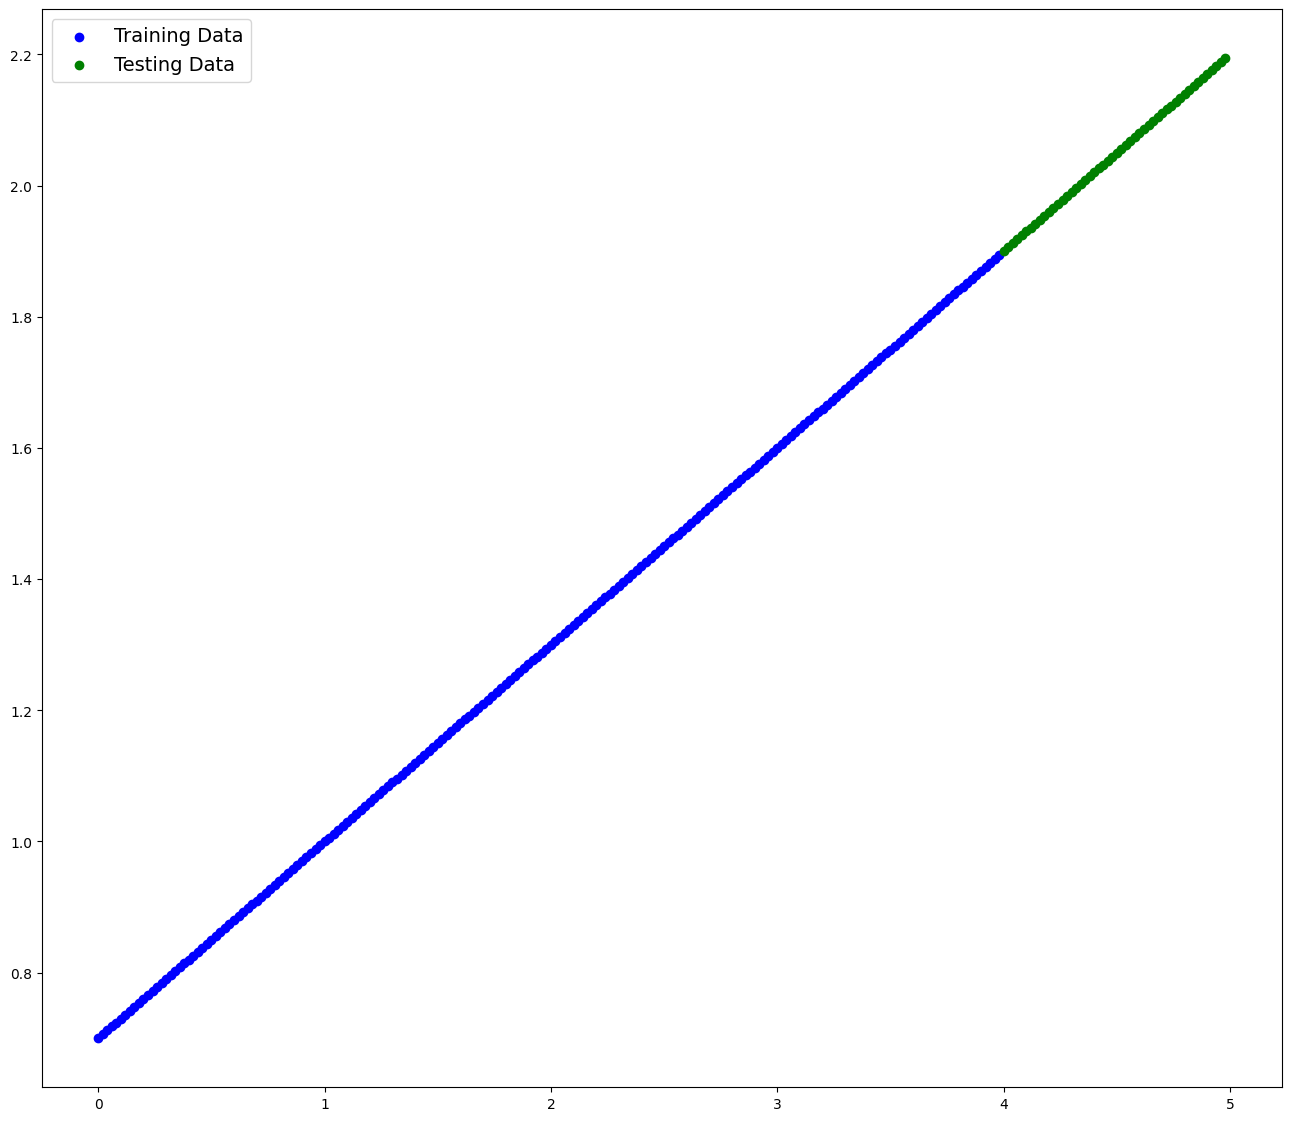

In [40]:
plot_predictions(X_train,y_train,X_test,y_test)

##6.2 Building a Pytorch Linear regression model

In [41]:
class LinearRegressionModelV2(nn.Module):
  def __init__(self):
    super().__init__()
    # Use nn.Linear() for creating the model parameters
    self.linear_layer = nn.Linear(in_features  = 1,
                                  out_features = 1)
  
  def forward(self, x):
    return self.linear_layer(x)

In [42]:
# set manual seed
torch.manual_seed(42)
model_1 = LinearRegressionModelV2()
model_1, model_1.state_dict()

(LinearRegressionModelV2(
   (linear_layer): Linear(in_features=1, out_features=1, bias=True)
 ),
 OrderedDict([('linear_layer.weight', tensor([[0.7645]])),
              ('linear_layer.bias', tensor([0.8300]))]))

In [43]:
# set model to use the target device
model_1.to(device)

LinearRegressionModelV2(
  (linear_layer): Linear(in_features=1, out_features=1, bias=True)
)

### 6.3 Training

In [44]:
# Setup a loss function
loss_fn = nn.L1Loss()

# setup an Optimizer
Optimizer = torch.optim.SGD(params = model_1.parameters(), 
                            lr = 0.01)# lr ---> learning rate

In [49]:
# An epoch is one loop through the data
epochs = 200

# Loop through the data
for epoch in range(epochs):
  # set the model to training mode
  model_1.train() # train mode in PyTorch Sets all parameters that requires gradients
  
  # Forward Pass
  y_pred = model_1.forward(X_train)

  # calculate loss
  loss = loss_fn(y_pred,y_train)
  
  #Optimizer zero grad
  Optimizer.zero_grad()

  # backward prapogation
  loss.backward()
  
   # step the optimizer
  Optimizer.step()
  ### Testing
  model_0.eval()
  with torch.inference_mode(): # turns off gradient tracking & a couple more things behind the scenes
    #1. Do the forward pass
    test_pred = model_1(X_test)

    # 2. calculate loss
    test_loss = loss_fn(test_pred,y_test)
  
  #print Loss 
  if epoch % 10 == 0:
    print(f"Epoch : {epoch} | Loss : {loss} | Test Loss : {test_loss}")

Epoch : 0 | Loss : 0.04118931666016579 | Test Loss : 0.006426310632377863
Epoch : 10 | Loss : 0.04118931666016579 | Test Loss : 0.006426310632377863
Epoch : 20 | Loss : 0.04118931666016579 | Test Loss : 0.006426310632377863
Epoch : 30 | Loss : 0.04118931666016579 | Test Loss : 0.006426310632377863
Epoch : 40 | Loss : 0.04118931666016579 | Test Loss : 0.006426310632377863
Epoch : 50 | Loss : 0.04118931666016579 | Test Loss : 0.006426310632377863
Epoch : 60 | Loss : 0.04118931666016579 | Test Loss : 0.006426310632377863
Epoch : 70 | Loss : 0.04118931666016579 | Test Loss : 0.006426310632377863
Epoch : 80 | Loss : 0.04118931666016579 | Test Loss : 0.006426310632377863
Epoch : 90 | Loss : 0.04118931666016579 | Test Loss : 0.006426310632377863
Epoch : 100 | Loss : 0.04118931666016579 | Test Loss : 0.006426310632377863
Epoch : 110 | Loss : 0.04118931666016579 | Test Loss : 0.006426310632377863
Epoch : 120 | Loss : 0.04118931666016579 | Test Loss : 0.006426310632377863
Epoch : 130 | Loss : 0.

In [50]:
model_1.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.3207]])),
             ('linear_layer.bias', tensor([0.7000]))])

### 6.4 Making and evaluating predictions

In [51]:
# Turn Model into evalution mode
model_1.eval()

# make predictions on the test data
with torch.inference_mode():
  y_pred = model_1(X_test)

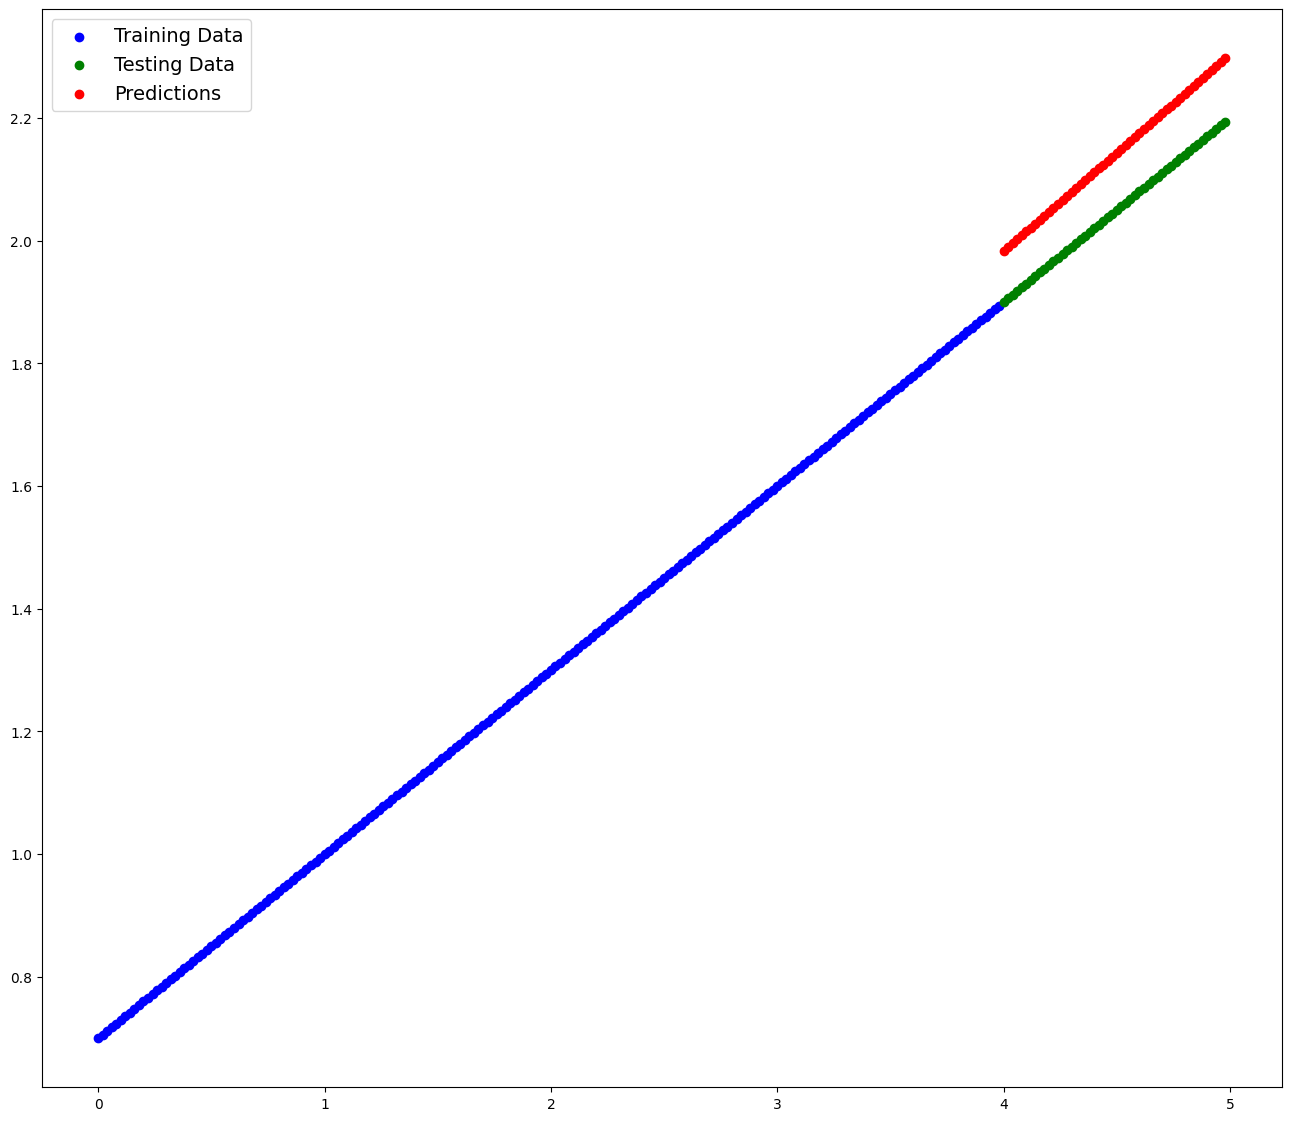

In [52]:
plot_predictions(X_train,y_train,X_test,y_test,y_pred)